In [1]:
from codes.requirements import *
from codes.functions import * 
pd.options.mode.chained_assignment = None 

In [2]:
###
### load data
###

vessels_design_speeds = pd.read_csv('data/vessels_design_speeds.csv', sep = ';')
vessels_speed_profile = pd.read_csv('data/vessels_speed_profile.csv', sep = ';')
vessels_info = pd.read_excel('data/vessels_info.xlsx')

In [3]:
###
### compute max operational speed for all the vessels in the vessels_speed_profile dataset
###

df = vessels_speed_profile.drop(list(vessels_speed_profile.columns)[:7], axis=1) # vessels_speed_profile df without "imo" column, starting from 3 knots-speed
list_of_speeds = np.arange(3, 30.5, 0.5) 
imo_df = vessels_speed_profile['imo'] 
max_op_speed_df = df.apply(compute_max_operational_speed, axis=1) 
imo_mos_df = pd.concat([imo_df, max_op_speed_df], axis = 1) # df with max operational speed values for all the vessels' imo
imo_mos_df.columns = ['Inst IMO No', 'max_op_speed']
#imo_mos_df.head()

In [4]:
###
### filtering by built-year and segments
###

vessels_info['built_year'] = pd.DatetimeIndex(vessels_info['Inst BuiltDate']).year # add built-year column
filtered_vessels_info = vessels_info[vessels_info['built_year'] > 2005] # filter by built year
filtered_vessels_info = vessels_info[vessels_info['Inst Cluster'].isin(['Cruise Vessels', 'Passenger Vessels', 'Passenger & Cargo Vessels', 'RoRo Vessels',
                                                                        'Gas Tankers', 'Container Vessels', 'Cargo Vessels', 'Bulk Carriers',
                                                                        'Tankers'])] # filter by vessel segment

In [5]:
###
# wartsila vessels present in vessels_info dataset  but not in speed_profile dataset
# for this reason we can't consider them in our computations
###

print('Dataset about vessels profile speed does not contain the following wartsila vessels that are in dataset about vessels info:')
print('\n')
print(set(filtered_vessels_info['Inst IMO No'].values) - set(imo_mos_df['Inst IMO No'].values))
print('\n')
print('Because we do not have info about sailing time for these vessels, we cant consider them in our computations.')

Dataset about vessels profile speed does not contain the following wartsila vessels that are in dataset about vessels info:


{6188121, 6145827, 6333157, 6183496, 6254089, 6175433, 6170577, 6414998, 6156855, 6183128, 6507257, 6169595, 6157532}


Because we do not have info about sailing time for these vessels, we cant consider them in our computations.


In [6]:
###
### find vessels wartsila vessels EPL-addressable
###

filtered_vessels_info['main engine power 85'] = filtered_vessels_info['Main Engine Power (kW)'] *0.85 # add column with 85% of main engine power
imo_85_df = filtered_vessels_info[['Inst IMO No', 'main engine power 85']] # df with imo values and corresponding 85% of main engine power for wartsila vessels
dd1 = pd.merge(imo_mos_df, imo_85_df, on = ['Inst IMO No']) # df with imo, max operational speed and 85% of main engine power for wartsila vessels
dd1.rename(columns = {'Inst IMO No': 'IMO'}, inplace = True) 
dd2 = pd.merge(dd1, vessels_design_speeds, on = ['IMO']) # df with imo, 85% main engine power and design speed for wartsila vessels
dd2['real_propulsion_power'] = dd2.apply(real_prop_power, axis = 1) # add real prop power demand 
dd2['EPL'] = dd2.apply(check, axis = 1) # add EPL addressable (if yes 1, else 0)
vessels_under_epl = dd2[dd2['EPL'] == 1] # df with vessels that under EPL maintain their operational profile
filtered_vessels_info.rename(columns = {'Inst IMO No': 'IMO'}, inplace='true')
epl_vessels_all_info = pd.merge(vessels_under_epl,filtered_vessels_info, on = ['IMO']) #info_vessels df for wartsila vessels EPL-addressable

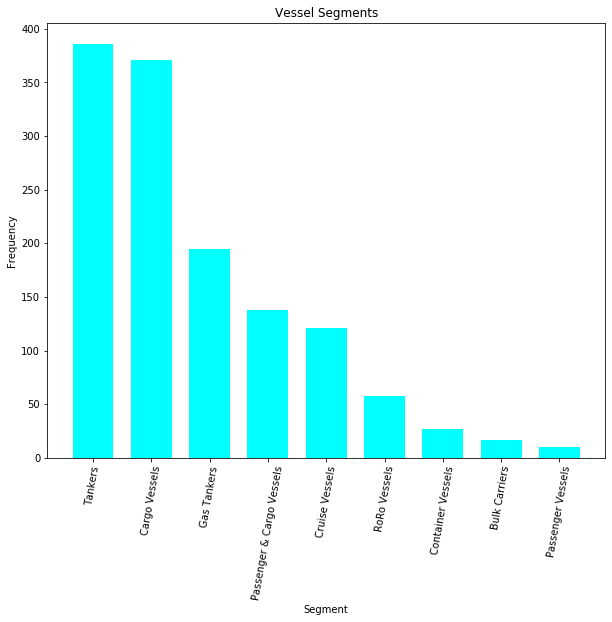

In [7]:
plot_frequency(epl_vessels_all_info,'Inst Cluster', 'cyan', 'Vessel Segments', 'segments','Segment')

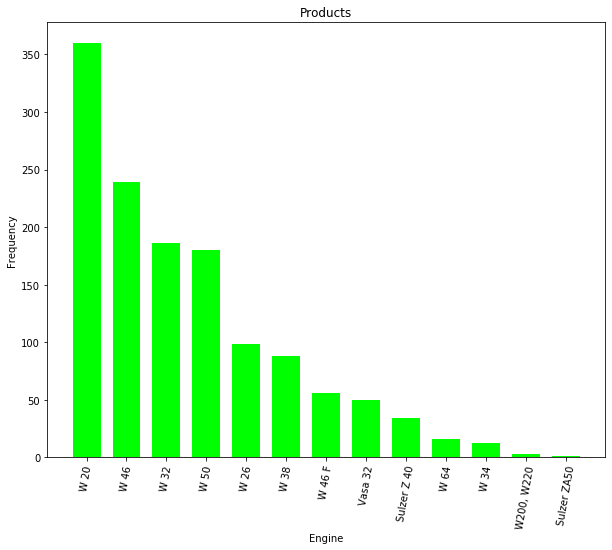

In [8]:
plot_frequency(epl_vessels_all_info,'Product', 'lime', 'Products','products','Engine')

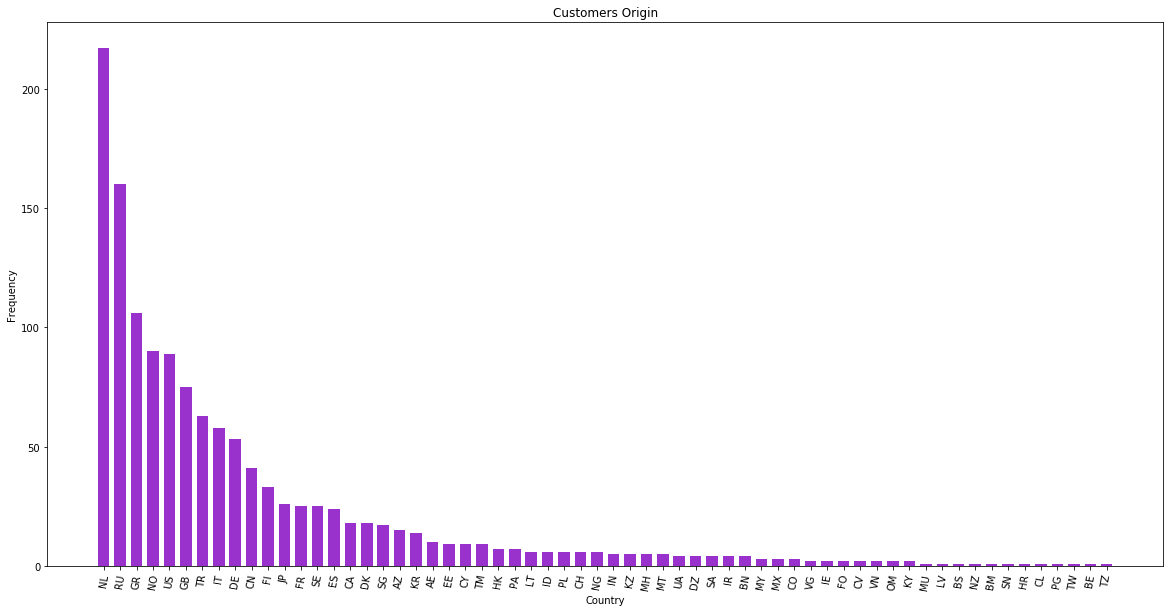

In [9]:
plot_frequency2(epl_vessels_all_info,'Customer Country', 'darkorchid', 'Customers Origin')

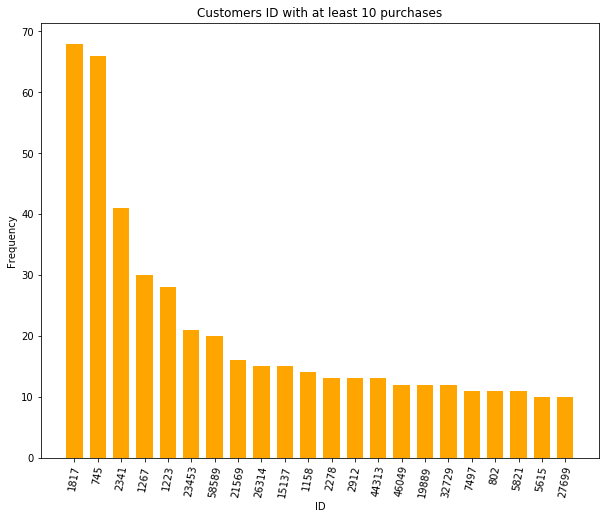

In [10]:
plot_frequency3(epl_vessels_all_info)